In [1]:
# General Imports
import os, sys
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, random_split, Dataset
sys.path.insert(0, '../')
from utils.fixes import global_seed

global_seed(42)
%matplotlib inline

Global seed set to 42


In [2]:
chk = pd.read_csv('./dataset.csv')
mols = pd.read_csv('../genetic_algorithm/test.csv')

In [3]:
chk.columns = ['name', 'score']
chk.head()

,name,score
0,0_6_4361,-10.033333
1,4_2_6567,-12.700000
2,1_4_350,-12.500000
3,0_6_571,-9.666667
4,2_2_62,-12.433333


In [74]:
chk.shape

(76984, 2)

In [4]:
mols.head()

,name,smiles
0,0_0_0,O=C(CCCC[C@@H]1CCSS1)NCCCCCCNC(=O)c1ccc(-c2c3n...
1,0_0_1,O=C(NCCCCCCNC(=O)c1ccc(-c2c3nc(c(-c4c(F)c(F)c(...
2,0_0_2,Nc1c(CC(=O)NCCCCCCNC(=O)c2ccc(-c3c4nc(c(-c5c(F...
3,0_0_3,CC(C)(C)c1cc2c(cc1Cl)C=C(C(=O)NCCCCCCNC(=O)c1c...
4,0_0_4,O=C(Cc1ccccc1Nc1c(Cl)cccc1Cl)NCCCCCCNC(=O)c1cc...


In [5]:
merged = pd.merge(chk, mols, on='name', how='left')

In [6]:
merged.head()

,name,score,smiles
0,0_6_4361,-10.033333,O=C(OCCOCCOCCOCCOC(=O)c1ccc(S(=O)(=O)Nc2ccccc2...
1,4_2_6567,-12.700000,Cc1ccccc1N(CCC(=O)NCCCNC(=O)c1ccc(-c2c3nc(c(-c...
2,1_4_350,-12.500000,CS(=O)(=O)c1ccc(-c2cc(Cl)cc3c2OC(C(F)(F)F)C(C(...
3,0_6_571,-9.666667,COc1ccccc1[C@@H]1CN(Cc2cc(C(C)=O)cn2C)C[C@H]1C...
4,2_2_62,-12.433333,CCCc1cc(S(F)(F)(F)(F)F)cc2c1OC(C(F)(F)F)C(C(=O...


In [9]:
merged.shape

(77491, 3)

In [10]:
merged.drop_duplicates(inplace=True)

In [11]:
merged.head()

,name,score,smiles
0,0_6_4361,-10.033333,O=C(OCCOCCOCCOCCOC(=O)c1ccc(S(=O)(=O)Nc2ccccc2...
1,4_2_6567,-12.700000,Cc1ccccc1N(CCC(=O)NCCCNC(=O)c1ccc(-c2c3nc(c(-c...
2,1_4_350,-12.500000,CS(=O)(=O)c1ccc(-c2cc(Cl)cc3c2OC(C(F)(F)F)C(C(...
3,0_6_571,-9.666667,COc1ccccc1[C@@H]1CN(Cc2cc(C(C)=O)cn2C)C[C@H]1C...
4,2_2_62,-12.433333,CCCc1cc(S(F)(F)(F)(F)F)cc2c1OC(C(F)(F)F)C(C(=O...


In [12]:
def could_be_mol(smiles):
    try:
        Chem.MolFromSmiles(smiles)
        return True
    except:
        return False

In [7]:
if os.path.exists('./ready_dataset.csv'):
    merged = pd.read_csv('./ready_dataset.csv')
else:
    merged['could_be_mol'] = merged['smiles'].apply(could_be_mol)
    print(merged['could_be_mol'].value_counts())
    merged = merged[merged['could_be_mol']]
    merged.to_csv('./ready_dataset.csv', index=False)

In [8]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load("model_300dim.pkl")

In [9]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

In [10]:
def sentences2vec(sentences, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.

    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032

    Returns
    -------
    np.array
    """

    keys = set(model.wv.key_to_index)
    vec = []

    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence
                            if y in set(sentence) & keys]))
    return np.array(vec)

In [11]:
def generate_mol_vector(mol):
    mol_sentence = MolSentence(mol2alt_sentence(mol, 1))
    mol_sentences = [mol_sentence]
    mol2vec = DfVec(sentences2vec(mol_sentences, model, unseen='UNK'))
    vector = mol2vec.vec
    return np.squeeze(vector)

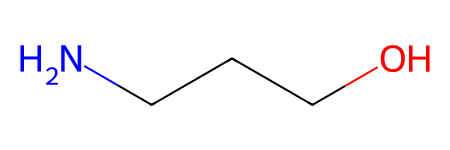

In [12]:
test_mol = Chem.MolFromSmiles('NCCCO')
test_mol

In [13]:
generate_mol_vector(test_mol).shape

(300,)

In [14]:
import time
CALLS = []
target = merged.score.values
def get_score(id):
    global CALLS
    CALLS.append(id)
    return target[id]

In [15]:
from sklearn.neighbors import NearestNeighbors
import torch
import warnings
from multiprocessing import Pool

def smi2mol(smi):
    return Chem.MolFromSmiles(smi)

class ChemicalSpace:
    def __init__(self, file):
        if file.split('.')[-1] == 'csv':
            compounds = pd.read_csv(file, delimiter = ",", nrows=50000)
        elif file.split('.')[-1] == 'smi':
            raise NotImplementedError
        else:
            raise NotImplementedError
        self.compounds = compounds
        print(f"Generating RDKit molecules from SMILES...")
        with Pool(16) as p:
            self.compounds['mol'] = p.map(smi2mol, self.compounds['smiles'])
        print(f"Generating Mol2Vec sentences from RDKit molecules...")
        #self.compounds['mol_sentence'] = self.compounds.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)
        print(f"Generating Mol2Vec vectors from Mol2Vec sentences...")
        #self.mol2vec = np.array([DfVec(x).vec for x in sentences2vec(self.compounds['mol_sentence'], model, unseen='UNK')])
        with Pool(16) as p:
            self.mol2vec = np.array(p.map(generate_mol_vector, self.compounds['mol']))
        split = {f'vec_{i}': self.mol2vec[:, i] for i in range(self.mol2vec.shape[1])}
        self.vecs = pd.DataFrame(split)
        self.scores_cache = {}
        self.iter_neighbors = set()
    def init_knn(self, n_neighbors=5):
        self.nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(self.mol2vec)
    def get_neighbors(self, vec, return_distance=False):
        if len(vec.shape) == 1:
            vec = vec.reshape(1, -1)
        return self.nbrs.kneighbors(vec, return_distance=return_distance)
    def set_objective(self, objective, **kwargs):
        # objective is a function that takes in an id and returns a score
        self.objective = objective
        self.objective_kwargs = kwargs
    def get_objective(self, id):
        if id not in self.scores_cache:
            self.scores_cache[id] = self.objective(id, **self.objective_kwargs)
        return self.scores_cache[id]
    def reset_neighbors(self):
        self.iter_neighbors = set()
    def add_step_neighbors(self, neighbors):
        self.iter_neighbors.update(neighbors)
    def f(self, X):
        if not isinstance(X, torch.Tensor):
            warnings.warn("X is not a torch tensor. Converting to torch tensor...")
            X = torch.tensor(X, dtype=torch.float, requires_grad=True)
        X_numpy = X.detach().numpy()
        # get neighbors
        neighbors = self.get_neighbors(X_numpy)[0]
        # add neighbors to list of neighbors
        self.add_step_neighbors(neighbors)
        # get scores of neighbors
        scores = torch.tensor([self.get_objective(i) for i in neighbors], dtype=torch.float64, requires_grad=True)
        # get coordinates of neighbors
        coords = torch.tensor([self.mol2vec[i] for i in neighbors], dtype=torch.float64, requires_grad=True)
        # f(x) = distance weighted average of neighbors
        # distance weighted average = sum of scores * (1 / distance)
        distance_sum = torch.sum(1 / torch.sqrt(torch.sum((coords - X)**2, axis=1)), dtype=torch.float64)
        scores = torch.sum(scores * (1 / torch.sqrt(torch.sum((coords - X)**2, axis=1))), dtype=torch.float64) / distance_sum
        return torch.mean(scores)

In [16]:
smi = 'ready_dataset.csv'

In [17]:
space = ChemicalSpace(smi) # 2.37 min -> 45 s

Generating RDKit molecules from SMILES...
Generating Mol2Vec sentences from RDKit molecules...
Generating Mol2Vec vectors from Mol2Vec sentences...


In [18]:
space.mol2vec[0].shape

(300,)

In [19]:
space.init_knn(n_neighbors=10)

In [20]:
space.iter_neighbors

set()

In [21]:
space.get_neighbors(space.mol2vec[7]) # array([[    7, 17470, 44365, 32345, 44939,  6501, 20274,  2738,  3009, 47089]])

array([[    7, 17470, 44365, 32345, 44939,  6501, 20274,  2738,  3009,
        47089]])

In [22]:
space.get_neighbors(space.mol2vec[844])

array([[  844, 20928, 24058, 20818, 32114, 44001, 14578, 49724, 19592,
        18333]])

In [23]:
space.set_objective(get_score)

In [24]:
space.get_objective(84) # 10.63

-10.633333333333333

In [25]:
%%time
space.get_objective(8)

CPU times: user 15 µs, sys: 4 µs, total: 19 µs
Wall time: 21.5 µs


-11.133333333333333

In [26]:
debug_vector = torch.rand(300, requires_grad=True)

In [27]:
space.f(debug_vector * 10)

/tmp/ipykernel_498/1364553174.py:61: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1660083882787/work/torch/csrc/utils/tensor_new.cpp:201.)
  coords = torch.tensor([self.mol2vec[i] for i in neighbors], dtype=torch.float64, requires_grad=True)


tensor(-9.3738, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [28]:
space.iter_neighbors

{644, 944, 2549, 2605, 6483, 7428, 15419, 19411, 25526, 32220}

In [29]:
from utils import *
global_seed(654)

Global seed set to 654


In [30]:
def create_distribs(mol2vec):
    means = np.ones(mol2vec.shape[1])
    stds = np.ones(mol2vec.shape[1])
    for i in range(mol2vec.shape[1]):
        means[i] = np.mean(mol2vec[:, i])
        stds[i] = np.std(mol2vec[:, i])
    return means, stds
def sample_from_distribs(means, stds):
    return np.random.normal(means, stds)

In [31]:
means, stds = create_distribs(space.mol2vec)

In [31]:
# import seaborn as sns
# # plot all means as distribution
# sns.set_style('whitegrid')
# numeric_dists = [np.random.normal(means[i], stds[i], 30000) for i in range(len(means))]
# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# for i in tqdm(range(len(numeric_dists))):    
#     sns.histplot(numeric_dists[i], ax=ax, label=f'feature {i}', kde=True, stat='probability')
# ax.set_title('Distribution of features in latent space')
# ax.set_xlabel('Feature value')
# # make borders smaller
# fig.savefig('latent_space_distributions.png', dpi=300, bbox_inches='tight')

In [32]:
# optimize f(x)
X = torch.tensor(sample_from_distribs(means, stds), dtype=torch.float, requires_grad=True)

In [33]:
from torch.optim import Adam
optimizer = Adam([X], lr=10)

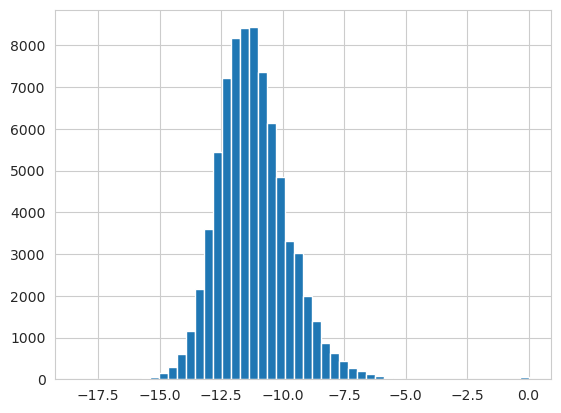

In [34]:
import seaborn as sns
sns.set_style('whitegrid')
_ = plt.hist(target, bins=50)

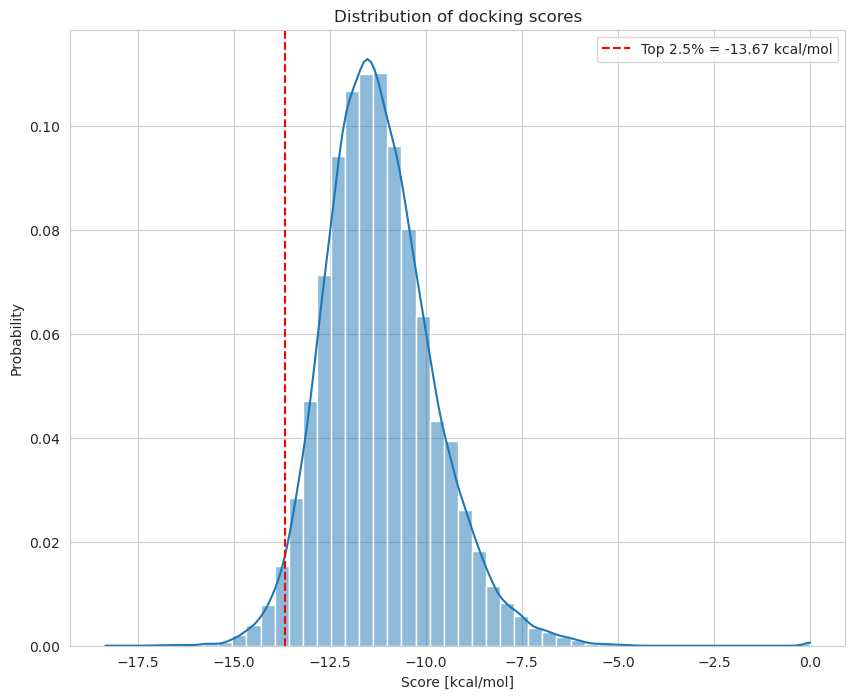

In [45]:
import seaborn as sns
# add frame to plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.set_style('whitegrid')
_=sns.histplot(target, bins=50, ax=ax, kde=True, stat='probability')
ax.set_title('Distribution of docking scores')
ax.set_xlabel('Score [kcal/mol]')
ax.set_ylabel('Probability')
# plot top 2.5% of scores cutoff
ax.axvline(np.percentile(target, 2.5), color='red', linestyle='--', label=f'Top 2.5% = {np.percentile(target, 2.5):.2f} kcal/mol')
ax.legend()
fig.savefig('docking_scores.png', dpi=300, bbox_inches='tight')

In [46]:
CALLS = []
best = 0
for i in range(5000):
    optimizer.zero_grad()
    loss = space.f(X)
    loss.backward()
    optimizer.step()
    if loss.item() < best:
        best = loss.item()
    if i % 500 == 0:
        print(f'Iteration: {i}', f'Loss: {loss.item()}')

Iteration: 0 Loss: -11.585361692918395
Iteration: 500 Loss: -14.533304555247124
Iteration: 1000 Loss: -14.077297250213704
Iteration: 1500 Loss: -8.6504925835567
Iteration: 2000 Loss: -12.816820754357721
Iteration: 2500 Loss: -13.773768543338942
Iteration: 3000 Loss: -14.493099823012189
Iteration: 3500 Loss: -9.39336335235886
Iteration: 4000 Loss: -9.623480765018753
Iteration: 4500 Loss: -9.673592745655933


In [47]:
from scipy.stats import percentileofscore
# flatten list of lists
def unique_comps(iter_neighbors):
    return len(set([item for sublist in iter_neighbors for item in sublist]))
print(f'Visited {len(space.iter_neighbors)} unique compounds')
print(f'Best score: {best}')
print(f'Percentile: {percentileofscore(target, best)}')

Visited 373 unique compounds
Best score: -14.767147026021995
Percentile: 0.26094671468086217


In [36]:
lrs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
lrs_timeline = {lr: [] for lr in lrs}
exploration_index = []

In [52]:
for lr in lrs:
    space.reset_neighbors()
    print(f'Learning rate: {lr}')
    global_seed(6765550)
    X = torch.tensor(sample_from_distribs(means, stds), dtype=torch.float, requires_grad=True)
    optimizer = Adam([X], lr=lr)
    for i in tqdm(range(2000)):
        optimizer.zero_grad()
        loss = space.f(X)
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            lrs_timeline[lr].append(loss.item())
    print(f'Visited {len(space.iter_neighbors)} points')
    exploration_index.append(len(space.iter_neighbors))

Learning rate: 0.0001
Global seed set to 6765550


  0%|          | 0/2000 [00:00<?, ?it/s]

Visited 17 points
Learning rate: 0.001
Global seed set to 6765550


  0%|          | 0/2000 [00:00<?, ?it/s]

Visited 25 points
Learning rate: 0.01
Global seed set to 6765550


  0%|          | 0/2000 [00:00<?, ?it/s]

Visited 40 points
Learning rate: 0.1
Global seed set to 6765550


  0%|          | 0/2000 [00:00<?, ?it/s]

Visited 42 points
Learning rate: 1
Global seed set to 6765550


  0%|          | 0/2000 [00:00<?, ?it/s]

Visited 69 points
Learning rate: 10
Global seed set to 6765550


  0%|          | 0/2000 [00:00<?, ?it/s]

Visited 224 points
Learning rate: 100
Global seed set to 6765550


  0%|          | 0/2000 [00:00<?, ?it/s]

Visited 46 points


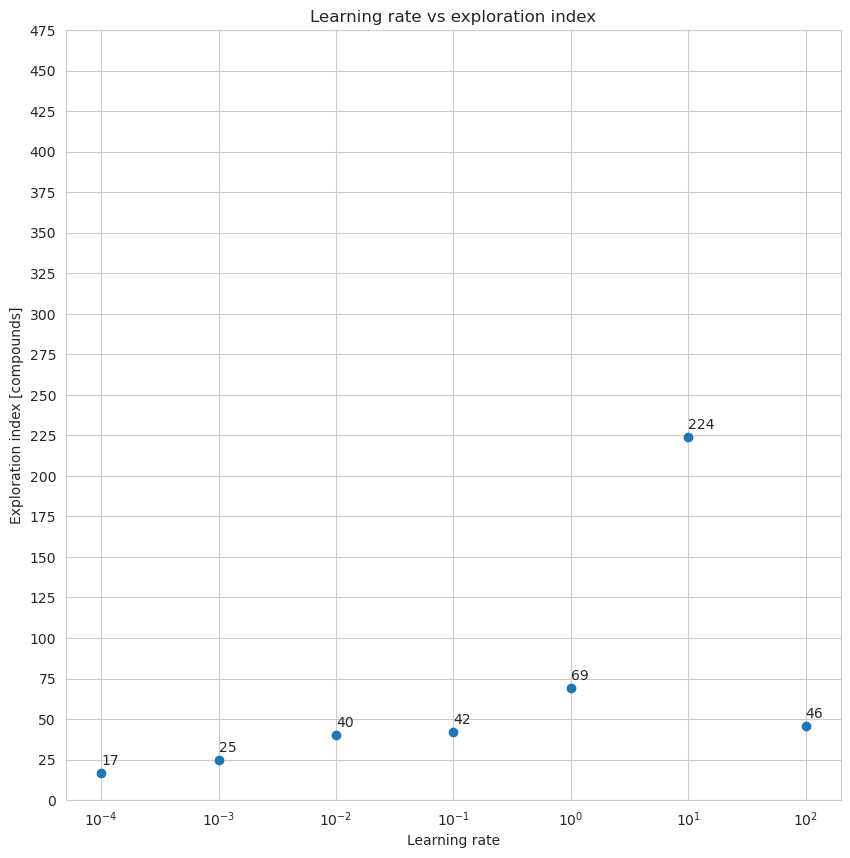

In [53]:
# plot learning rate vs exploration index plot in log scale
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(lrs, exploration_index, 'o')
ax.set_xscale('log')
#add y ticks for exploration index
ax.set_yticks(range(0, 500, 25))
for i, txt in enumerate(exploration_index):
    ax.annotate(txt, (lrs[i], exploration_index[i]+5))
ax.set_xlabel('Learning rate')
ax.set_ylabel('Exploration index [compounds]')
ax.set_title('Learning rate vs exploration index')
plt.show()

In [54]:
for lr in lrs:
    print(f'Best score for lr={lr}: {np.min(lrs_timeline[lr]):.3f}')

Best score for lr=0.0001: -11.445
Best score for lr=0.001: -12.216
Best score for lr=0.01: -14.295
Best score for lr=0.1: -14.268
Best score for lr=1: -13.946
Best score for lr=10: -14.501
Best score for lr=100: -13.917


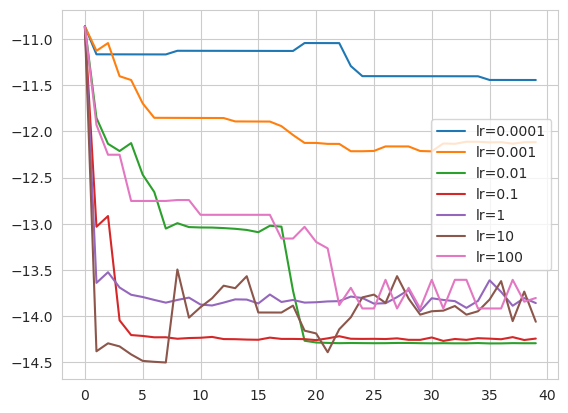

In [55]:
for lr in lrs:
    _ = plt.plot(lrs_timeline[lr], label=f'lr={lr}')
plt.legend()

In [56]:
from scipy import stats

In [58]:
#percentile of each best logP
for lr, exp in zip(lrs, exploration_index):
    print(f'Percentile of best score for lr={lr}: {stats.percentileofscore(target, np.min(lrs_timeline[lr])):.3f} with {exp} samples')

Percentile of best score for lr=0.0001: 46.058 with 17 samples
Percentile of best score for lr=0.001: 23.408 with 25 samples
Percentile of best score for lr=0.01: 0.757 with 40 samples
Percentile of best score for lr=0.1: 0.757 with 42 samples
Percentile of best score for lr=1: 1.455 with 69 samples
Percentile of best score for lr=10: 0.487 with 224 samples
Percentile of best score for lr=100: 1.538 with 46 samples


In [59]:
# calcuate probability of each best logP is sampled from target distribution
for lr, exp in zip(lrs, exploration_index):
    samples = np.random.choice(target, exp)
    if exp == 0:
        print(f'Probability of best score for lr={lr}: 0 with {exp} samples')
    else:
        print(f'Probability of best score for lr={lr}: {np.sum(samples < np.min(lrs_timeline[lr])) / exp} with {exp} samples')


Probability of best score for lr=0.0001: 0.4117647058823529 with 17 samples
Probability of best score for lr=0.001: 0.28 with 25 samples
Probability of best score for lr=0.01: 0.0 with 40 samples
Probability of best score for lr=0.1: 0.023809523809523808 with 42 samples
Probability of best score for lr=1: 0.0 with 69 samples
Probability of best score for lr=10: 0.004464285714285714 with 224 samples
Probability of best score for lr=100: 0.021739130434782608 with 46 samples


In [60]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(space.mol2vec)

PCA(n_components=2)

/tmp/ipykernel_10949/288582114.py:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(mapable)


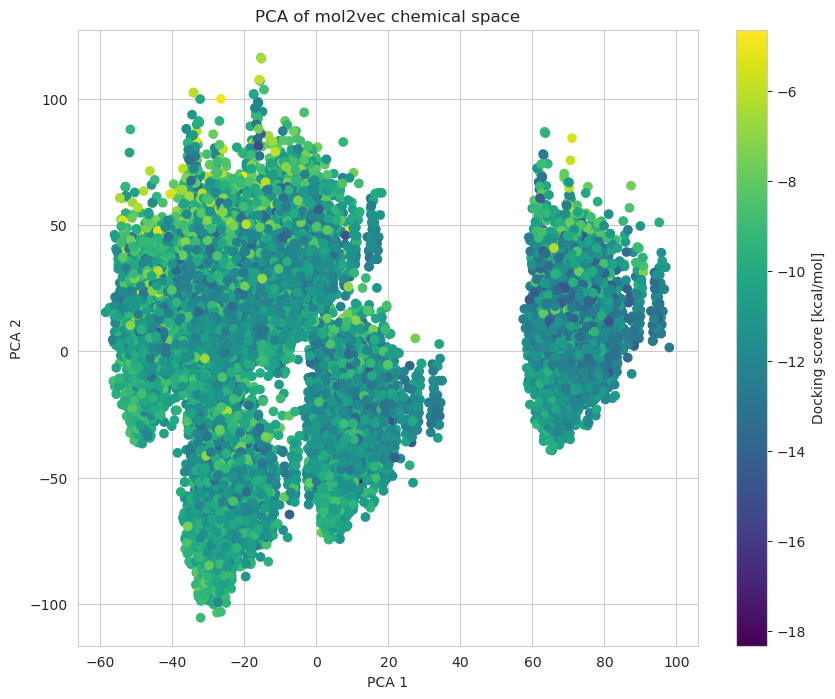

In [61]:
# plot PCA of mol2vec, use target as color
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(pca.transform(space.mol2vec)[:, 0], pca.transform(space.mol2vec)[:, 1], c=target[:50000], cmap='viridis')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_title('PCA of mol2vec chemical space')
mapable = plt.cm.ScalarMappable(cmap='viridis')
mapable.set_array(target[:50000])
cbar = fig.colorbar(mapable)
cbar.set_label('Docking score [kcal/mol]')

fig.savefig('pca.png', dpi=300, bbox_inches='tight')

In [53]:
# test evrything with lr 10
global_seed(676550)
X = torch.tensor(sample_from_distribs(means, stds), dtype=torch.float, requires_grad=True)
optimizer = Adam([X], lr=0.01)
CALLS = []
history = np.zeros(2000)

Global seed set to 676550


In [54]:
best = 0
best_X = None
space.reset_neighbors()
for i in range(2000):
    optimizer.zero_grad()
    loss = space.f(X)
    loss.backward()
    optimizer.step()
    history[i] = loss.item()
    if loss.item() < best:
        best = loss.item()
        best_f = space.f(X)
        best_X = X.clone().detach()
    if i % 100 == 0:
        print(f'Iteration {i}: {loss.item()}, neighbors: {space.get_neighbors(X.detach().numpy())}')

Iteration 0: -11.800604283433183, neighbors: [[ 8263  2837 16780 19436 29650 26083 12678  7318 25891 17207]]
Iteration 100: -12.17725691278613, neighbors: [[16780  8263  7318 19571 26083 24175  3393 19115 15828 22334]]
Iteration 200: -13.019136118281102, neighbors: [[ 8444 16780 19571 28204  4736 21592 10301  2267  5465 18720]]
Iteration 300: -13.422779419698216, neighbors: [[ 8444 28204  4736 10301 21592  9168 12213 19571 16780 14147]]
Iteration 400: -13.392307933903522, neighbors: [[ 8444 10301 28204  4736 21592  9168 12213 18816 19571  4374]]
Iteration 500: -13.305830469001913, neighbors: [[ 8444 10301 21592 28204  4736  9168  5465  2827 18816 19571]]
Iteration 600: -14.005241617425998, neighbors: [[ 8444 10301 21592  5465  2827 19571 21418 24109  9168 18816]]
Iteration 700: -15.869838809183356, neighbors: [[ 8444 10301 21592  5465  2827 21418 24109 19571  9168 16235]]
Iteration 800: -16.114612339688804, neighbors: [[ 8444 10301 21592  5465  2827 21418 24109  9168 19571  4374]]
Iter

In [55]:
space.get_neighbors(X.detach().numpy())
for i in space.get_neighbors(X.detach().numpy())[0]:
    print(space.get_objective(i))

-16.133333333333333
-13.300000000000002
-12.433333333333332
-11.566666666666668
-12.033333333333331
-12.366666666666667
-12.233333333333334
-12.066666666666668
-12.333333333333334
-12.7


In [56]:
print(f'Visited {unique_comps(space.iter_neighbors)} unique compounds')
print(f'Best score: {best}')
print(f'Percentile: {percentileofscore(target, best)}')
print(f'Best f(X): {best_f}')

Visited 47 unique compounds
Best score: -16.129409050400238
Percentile: 0.037837273628725014
Best f(X): -16.11413353977555


In [57]:
space.f(best_X)

tensor(-16.1141, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [58]:
np.sum(target < best)

29

In [59]:
for i in space.get_neighbors(best_X)[0]:
    print(space.get_objective(i))

-16.133333333333333
-13.300000000000002
-12.433333333333332
-11.566666666666668
-12.033333333333331
-12.366666666666667
-12.233333333333334
-12.066666666666668
-12.333333333333334
-12.7


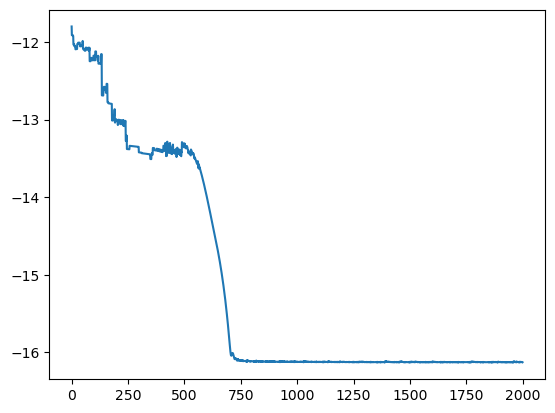

In [60]:
_ = plt.plot(history)

In [61]:
best_X

tensor([ 10.7435, -12.4907, -13.9022,  20.4168,  -9.2623,  -5.1384, -37.6056,
          2.8812,  28.2282,  17.6497, -10.0176,  -5.8981, -34.4853,   3.4457,
        -19.6775,  -6.9179,  13.5116, -13.8149, -16.3957,  26.5857,  14.7813,
         22.0685,  54.5305,  27.5932, -38.3574,   4.2319,  -1.9942, -32.2904,
         -0.8080,   1.4150,  42.4188, -26.1582, -12.4401, -18.9406,  17.9271,
          7.7917,   6.7873,  -2.6793,  32.5897,   9.0254,  -9.4453,  -2.4397,
        -11.8076,  -0.8447, -42.3179,  26.6574,   0.0819,  30.7090, -21.4143,
         15.7186,  20.1684, -21.8772,  -8.4330, -26.7457, -26.0855, -15.3500,
        -14.5754,   0.4629,  11.9352,  17.0587,  -8.0730, -31.2048,  -7.6596,
         12.6071, -49.0992,  -2.6900,  34.7361,   0.0627,  -6.9172,   4.2381,
        -18.2080,   5.9921,  25.7646, -20.9373,  -3.5780,  18.8211, -11.5482,
         12.7517,  -3.8737,   6.8868,  18.2838,  -7.1739, -15.0996, -40.6798,
          8.9273, -10.4790, -26.5929,  16.1466,  14.2246,  -9.23

In [62]:
space.f(best_X)

tensor(-16.1141, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [63]:
space.get_neighbors(best_X)

array([[ 8444, 10301, 21592,  5465,  2827, 21418, 24109,  9168, 19571,
         4374]])

In [64]:
for i in space.get_neighbors(best_X)[0]:
    print(space.get_objective(i))

-16.133333333333333
-13.300000000000002
-12.433333333333332
-11.566666666666668
-12.033333333333331
-12.366666666666667
-12.233333333333334
-12.066666666666668
-12.333333333333334
-12.7


In [79]:
def unique_comps(iter_neighbors):
    return len(set([item for sublist in iter_neighbors for item in sublist]))

In [32]:
def create_replica(n=25, steps=3000, lr=0.01):
    replica_dfs = []
    idxs = []
    best_objs = []
    for replica in tqdm(range(n)):
        space.reset_neighbors()
        print(f'Replica {replica}')
        global_seed(42 * replica)
        X = torch.tensor(sample_from_distribs(means, stds), dtype=torch.float, requires_grad=True)
        optimizer = Adam([X], lr=lr)
        history = np.zeros(steps)
        best = 0
        for i in range(steps):
            optimizer.zero_grad()
            loss = space.f(X)
            loss.backward()
            optimizer.step()
            history[i] = loss.item()
            if loss.item() < best:
                best = loss.item()
        res = pd.DataFrame({'step': range(steps), 'loss': history})
        res['replica'] = replica
        replica_dfs.append(res)
        idxs.append(len(space.iter_neighbors))
        best_objs.append(best)
    return pd.concat(replica_dfs), idxs, best_objs

In [36]:
lrs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
from torch.optim import Adam

In [41]:
scans2do = len(lrs)
perf_scanes = 0
elapsed = 0
lr_comp = []
exp_idxs = []
best_objs = []
for lr in lrs:
    start = time.time()
    res, exp_id, best_obj = create_replica(n=25, steps=3000, lr=lr)
    lr_comp.append(res)
    exp_idxs.append(exp_id)
    best_objs.append(best_obj)
    end = time.time()
    elapsed += end - start
    perf_scanes += 1
    print(f'Finished {perf_scanes} out of {scans2do} in {elapsed} seconds, {elapsed / perf_scanes} seconds per scan')
    print(f'Estimated time left: {((scans2do - perf_scanes) * elapsed / perf_scanes) / 60} minutes')


  0%|          | 0/25 [00:00<?, ?it/s]

Replica 0
Global seed set to 0
Replica 1
Global seed set to 42
Replica 2
Global seed set to 84
Replica 3
Global seed set to 126
Replica 4
Global seed set to 168
Replica 5
Global seed set to 210
Replica 6
Global seed set to 252
Replica 7
Global seed set to 294
Replica 8
Global seed set to 336
Replica 9
Global seed set to 378
Replica 10
Global seed set to 420
Replica 11
Global seed set to 462
Replica 12
Global seed set to 504
Replica 13
Global seed set to 546
Replica 14
Global seed set to 588
Replica 15
Global seed set to 630
Replica 16
Global seed set to 672
Replica 17
Global seed set to 714
Replica 18
Global seed set to 756
Replica 19
Global seed set to 798
Replica 20
Global seed set to 840
Replica 21
Global seed set to 882
Replica 22
Global seed set to 924
Replica 23
Global seed set to 966
Replica 24
Global seed set to 1008
Finished 1 out of 7 in 1760.160144329071 seconds, 1760.160144329071 seconds per scan
Estimated time left: 176.0160144329071 minutes


  0%|          | 0/25 [00:00<?, ?it/s]

Replica 0
Global seed set to 0
Replica 1
Global seed set to 42
Replica 2
Global seed set to 84
Replica 3
Global seed set to 126
Replica 4
Global seed set to 168
Replica 5
Global seed set to 210
Replica 6
Global seed set to 252
Replica 7
Global seed set to 294
Replica 8
Global seed set to 336
Replica 9
Global seed set to 378
Replica 10
Global seed set to 420
Replica 11
Global seed set to 462
Replica 12
Global seed set to 504
Replica 13
Global seed set to 546
Replica 14
Global seed set to 588
Replica 15
Global seed set to 630
Replica 16
Global seed set to 672
Replica 17
Global seed set to 714
Replica 18
Global seed set to 756
Replica 19
Global seed set to 798
Replica 20
Global seed set to 840
Replica 21
Global seed set to 882
Replica 22
Global seed set to 924
Replica 23
Global seed set to 966
Replica 24
Global seed set to 1008
Finished 2 out of 7 in 3555.689296722412 seconds, 1777.844648361206 seconds per scan
Estimated time left: 148.15372069676718 minutes


  0%|          | 0/25 [00:00<?, ?it/s]

Replica 0
Global seed set to 0
Replica 1
Global seed set to 42
Replica 2
Global seed set to 84
Replica 3
Global seed set to 126
Replica 4
Global seed set to 168
Replica 5
Global seed set to 210
Replica 6
Global seed set to 252
Replica 7
Global seed set to 294
Replica 8
Global seed set to 336
Replica 9
Global seed set to 378
Replica 10
Global seed set to 420
Replica 11
Global seed set to 462
Replica 12
Global seed set to 504
Replica 13
Global seed set to 546
Replica 14
Global seed set to 588
Replica 15
Global seed set to 630
Replica 16
Global seed set to 672
Replica 17
Global seed set to 714
Replica 18
Global seed set to 756
Replica 19
Global seed set to 798
Replica 20
Global seed set to 840
Replica 21
Global seed set to 882
Replica 22
Global seed set to 924
Replica 23
Global seed set to 966
Replica 24
Global seed set to 1008
Finished 3 out of 7 in 4915.983913660049 seconds, 1638.6613045533497 seconds per scan
Estimated time left: 109.24408697022332 minutes


  0%|          | 0/25 [00:00<?, ?it/s]

Replica 0
Global seed set to 0
Replica 1
Global seed set to 42
Replica 2
Global seed set to 84
Replica 3
Global seed set to 126
Replica 4
Global seed set to 168
Replica 5
Global seed set to 210
Replica 6
Global seed set to 252
Replica 7
Global seed set to 294
Replica 8
Global seed set to 336
Replica 9
Global seed set to 378
Replica 10
Global seed set to 420
Replica 11
Global seed set to 462
Replica 12
Global seed set to 504
Replica 13
Global seed set to 546
Replica 14
Global seed set to 588
Replica 15
Global seed set to 630
Replica 16
Global seed set to 672
Replica 17
Global seed set to 714
Replica 18
Global seed set to 756
Replica 19
Global seed set to 798
Replica 20
Global seed set to 840
Replica 21
Global seed set to 882
Replica 22
Global seed set to 924
Replica 23
Global seed set to 966
Replica 24
Global seed set to 1008
Finished 4 out of 7 in 6120.180536270142 seconds, 1530.0451340675354 seconds per scan
Estimated time left: 76.50225670337677 minutes


  0%|          | 0/25 [00:00<?, ?it/s]

Replica 0
Global seed set to 0
Replica 1
Global seed set to 42
Replica 2
Global seed set to 84
Replica 3
Global seed set to 126
Replica 4
Global seed set to 168
Replica 5
Global seed set to 210
Replica 6
Global seed set to 252
Replica 7
Global seed set to 294
Replica 8
Global seed set to 336
Replica 9
Global seed set to 378
Replica 10
Global seed set to 420
Replica 11
Global seed set to 462
Replica 12
Global seed set to 504
Replica 13
Global seed set to 546
Replica 14
Global seed set to 588
Replica 15
Global seed set to 630
Replica 16
Global seed set to 672
Replica 17
Global seed set to 714
Replica 18
Global seed set to 756
Replica 19
Global seed set to 798
Replica 20
Global seed set to 840
Replica 21
Global seed set to 882
Replica 22
Global seed set to 924
Replica 23
Global seed set to 966
Replica 24
Global seed set to 1008
Finished 5 out of 7 in 7296.064580917358 seconds, 1459.2129161834716 seconds per scan
Estimated time left: 48.640430539449056 minutes


  0%|          | 0/25 [00:00<?, ?it/s]

Replica 0
Global seed set to 0
Replica 1
Global seed set to 42
Replica 2
Global seed set to 84
Replica 3
Global seed set to 126
Replica 4
Global seed set to 168
Replica 5
Global seed set to 210
Replica 6
Global seed set to 252
Replica 7
Global seed set to 294
Replica 8
Global seed set to 336
Replica 9
Global seed set to 378
Replica 10
Global seed set to 420
Replica 11
Global seed set to 462
Replica 12
Global seed set to 504
Replica 13
Global seed set to 546
Replica 14
Global seed set to 588
Replica 15
Global seed set to 630
Replica 16
Global seed set to 672
Replica 17
Global seed set to 714
Replica 18
Global seed set to 756
Replica 19
Global seed set to 798
Replica 20
Global seed set to 840
Replica 21
Global seed set to 882
Replica 22
Global seed set to 924
Replica 23
Global seed set to 966
Replica 24
Global seed set to 1008
Finished 6 out of 7 in 8507.896651268005 seconds, 1417.9827752113342 seconds per scan
Estimated time left: 23.633046253522238 minutes


  0%|          | 0/25 [00:00<?, ?it/s]

Replica 0
Global seed set to 0
Replica 1
Global seed set to 42
Replica 2
Global seed set to 84
Replica 3
Global seed set to 126
Replica 4
Global seed set to 168
Replica 5
Global seed set to 210
Replica 6
Global seed set to 252
Replica 7
Global seed set to 294
Replica 8
Global seed set to 336
Replica 9
Global seed set to 378
Replica 10
Global seed set to 420
Replica 11
Global seed set to 462
Replica 12
Global seed set to 504
Replica 13
Global seed set to 546
Replica 14
Global seed set to 588
Replica 15
Global seed set to 630
Replica 16
Global seed set to 672
Replica 17
Global seed set to 714
Replica 18
Global seed set to 756
Replica 19
Global seed set to 798
Replica 20
Global seed set to 840
Replica 21
Global seed set to 882
Replica 22
Global seed set to 924
Replica 23
Global seed set to 966
Replica 24
Global seed set to 1008
Finished 7 out of 7 in 10051.151475906372 seconds, 1435.8787822723389 seconds per scan
Estimated time left: 0.0 minutes


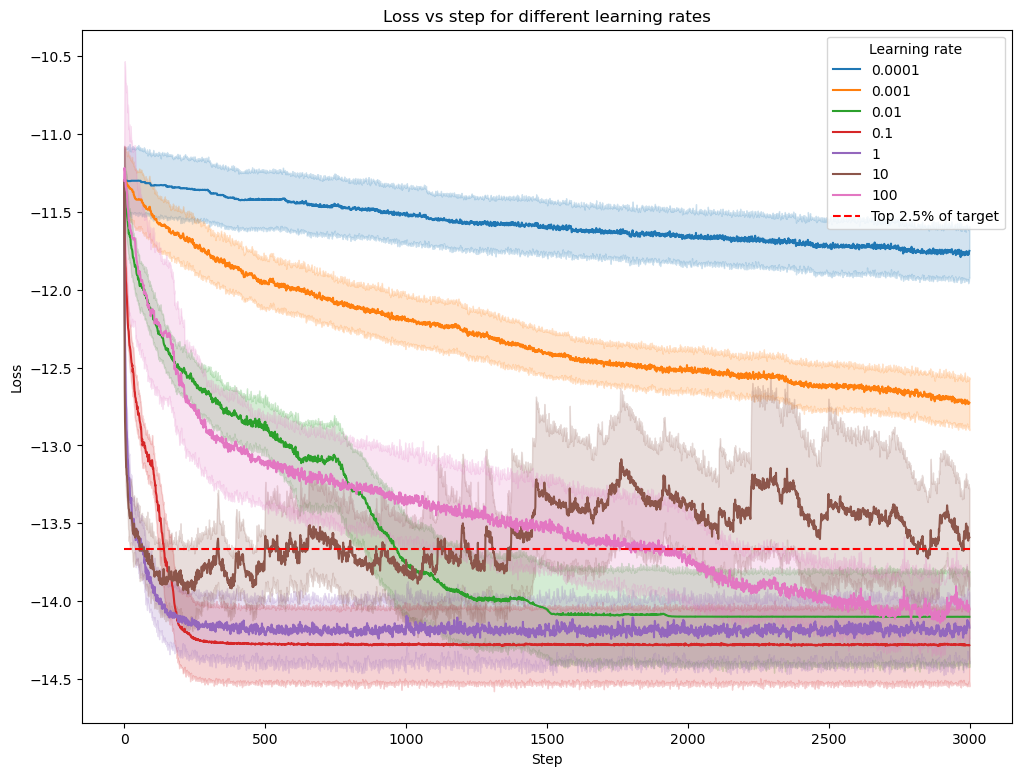

In [44]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
for df,lr in zip(lr_comp, lrs):
    sns.lineplot(data=df, x='step', y='loss',label=lr, ax=ax)
ax.set_title('Loss vs step for different learning rates')
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
cutoff = np.percentile(target, 2.5)
ax.hlines(cutoff, 0, 3000, color='red', linestyle='--', label=f'Top 2.5% of target')
# add name to legend
ax.legend(title='Learning rate')

In [47]:
ax.set_xlim(0, 3000)
ax.set_ylabel('Loss [kcal/mol]')
fig.savefig('loss_vs_step_replica.png', dpi=400, bbox_inches='tight')

In [48]:
from collections import namedtuple
def process_replicas(lrs, exp_idxs, best_objs):
    record = namedtuple('record', ['lr', 'exp_idx', 'best_obj'])
    records = []
    for lr in lrs:
        for exp_idx, best_obj in zip(exp_idxs[lrs.index(lr)], best_objs[lrs.index(lr)]):
            records.append(record(lr, exp_idx, best_obj))
    return pd.DataFrame(records)

In [49]:
df_sum = process_replicas(lrs, exp_idxs, best_objs)
df_sum.head()

,lr,exp_idx,best_obj
0,0.0001,15,-11.446457
1,0.0001,11,-11.871909
2,0.0001,12,-11.304504
3,0.0001,14,-12.361597
4,0.0001,13,-11.817214


In [51]:
df_sum.to_csv('replica_summary.csv', index=False)

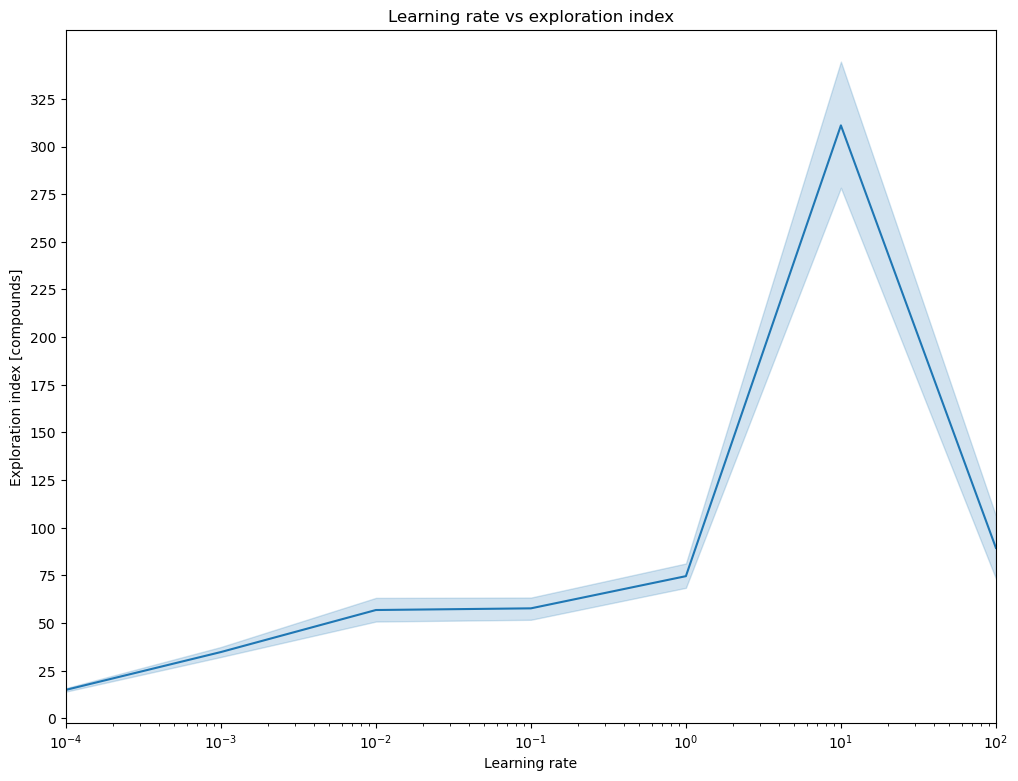

In [54]:
# plot learning rate vs exploration index plot in log scale
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
ax.set_xscale('log')
#add y ticks for exploration index
sns.lineplot(data=df_sum, x='lr', y='exp_idx', ax=ax)
ax.set_xlim(0.0001, 100)
ax.set_yticks(range(0, 350, 25))
ax.set_xlabel('Learning rate')
ax.set_ylabel('Exploration index [compounds]')
ax.set_title('Learning rate vs exploration index')
fig.savefig('lr_vs_exp_idx.png', dpi=400, bbox_inches='tight')
plt.show()

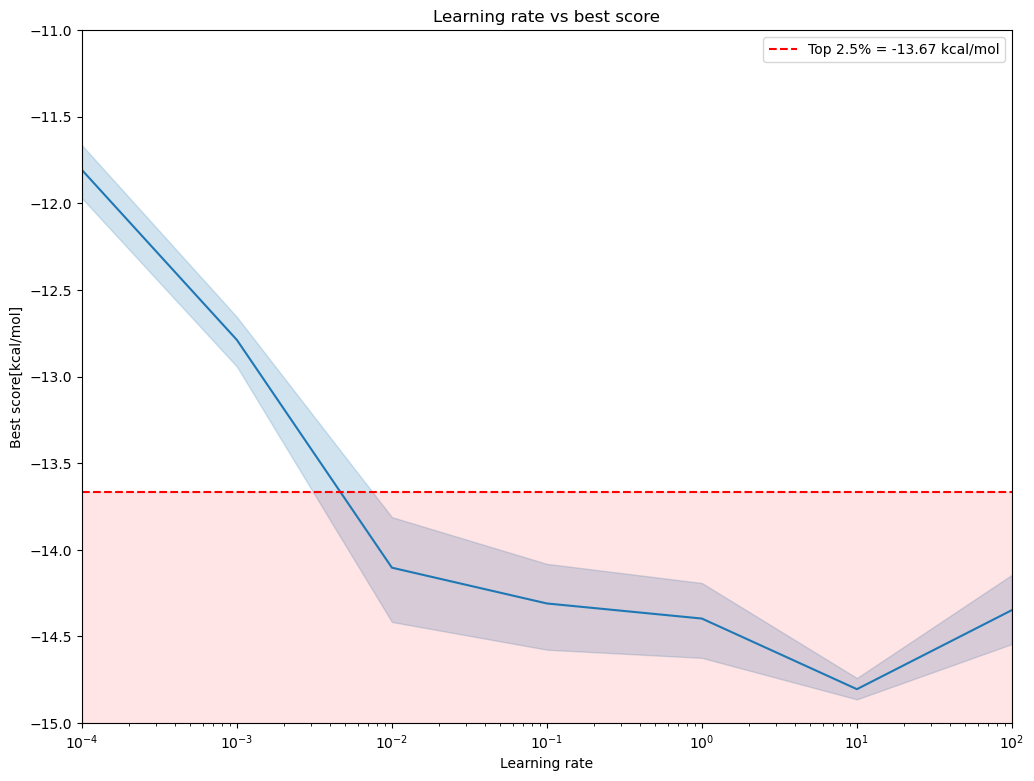

In [55]:
# plot learning rate vs best score
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
ax.set_xscale('log')
#add y ticks for exploration index
sns.lineplot(data=df_sum, x='lr', y='best_obj', ax=ax)
ax.set_xlim(0.0001, 100)
ax.set_xlabel('Learning rate')
ax.set_ylabel('Best score[kcal/mol]')
ax.set_title('Learning rate vs best score')
ax.hlines(np.percentile(target, 2.5), 0.0001, 100, color='red', linestyle='--', label=f'Top 2.5% = {np.percentile(target, 2.5):.2f} kcal/mol')
# color lower than 2.5% percentile
ax.fill_between([0.0001, 100], [np.percentile(target, 2.5), np.percentile(target, 2.5)], [-15,-15], color='red', alpha=0.1)
ax.set_ylim(-15, -11)
ax.legend()
fig.savefig('lr_vs_best_score.png', dpi=400, bbox_inches='tight')
plt.show()

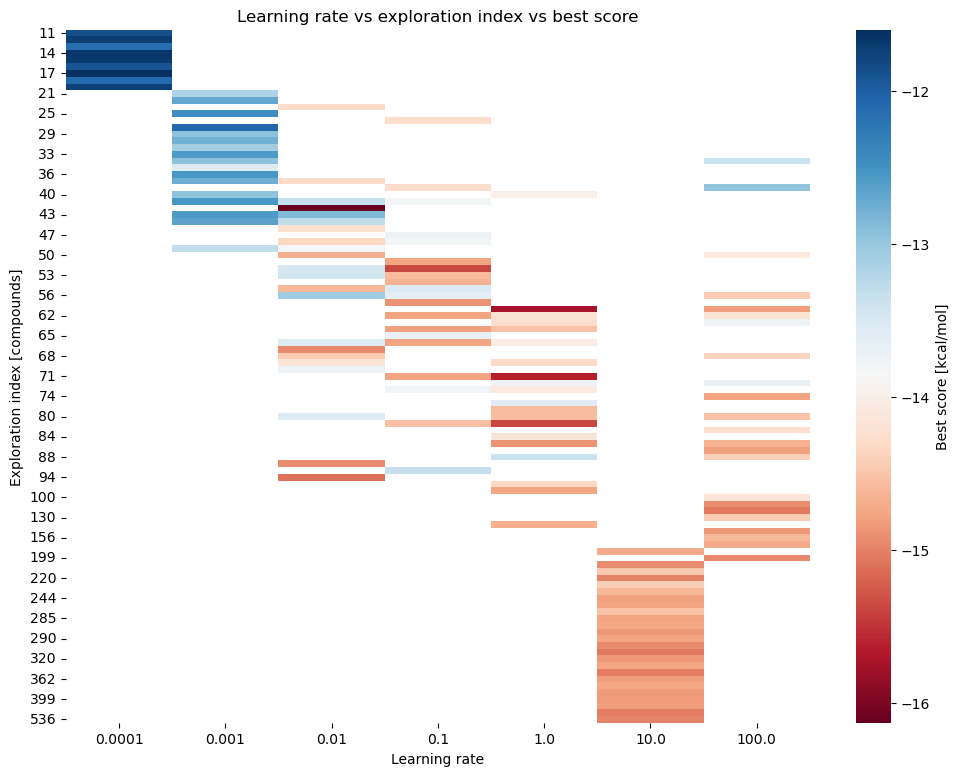

In [57]:
# heatmap of learning rate vs exploration index vs best score as color
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
sns.heatmap(df_sum.pivot_table(index='exp_idx', columns='lr', values='best_obj'), ax=ax, cmap='RdBu')
ax.set_xlabel('Learning rate')
ax.set_ylabel('Exploration index [compounds]')
ax.set_title('Learning rate vs exploration index vs best score')
# set cell to be square
# add description to colorbar
cbar = ax.collections[0].colorbar
cbar.set_label('Best score [kcal/mol]')
fig.savefig('lr_vs_exp_idx_vs_best_score_heatmap.png', dpi=400, bbox_inches='tight')
plt.show()

In [61]:
lr_comp[0].head()

,step,loss,replica
0,0,-11.129095,0
1,1,-11.129095,0
2,2,-11.129095,0
3,3,-11.129096,0
4,4,-11.129096,0


In [60]:
all_res = pd.concat(lr_comp)
all_res.to_csv('lr_compare.csv')

In [114]:
replica_dfs = []
steps = 2000
for replica in tqdm(range(50)):
    global_seed(42 * replica)
    X = torch.tensor(sample_from_distribs(means, stds), dtype=torch.float, requires_grad=True)
    optimizer = Adam([X], lr=0.1)
    CALLS = []
    history = np.zeros(steps)
    for i in range(steps):
        optimizer.zero_grad()
        loss = space.f(X)
        loss.backward()
        optimizer.step()
        history[i] = loss.item()
    res = pd.DataFrame({'step': range(steps), 'loss': history})
    res['replica'] = replica
    replica_dfs.append(res)

  0%|          | 0/50 [00:00<?, ?it/s]

Global seed set to 0
Global seed set to 42
Global seed set to 84
Global seed set to 126
Global seed set to 168
Global seed set to 210
Global seed set to 252


KeyboardInterrupt: 

In [117]:
global_seed(7543)
X = torch.tensor(sample_from_distribs(means, stds), requires_grad=True, dtype=torch.float64)
optimizer = Adam([X], lr=0.1)
CALLS = []
history = np.zeros(5000)
X_positions = np.zeros((5000, 300))
x_scores = np.zeros(5000)

Global seed set to 7543


In [118]:
best = 0
best_X = None
space.reset_neighbors()
for i in range(5000):
    optimizer.zero_grad()
    loss = space.f(X)
    loss.backward()
    optimizer.step()
    history[i] = loss.item()
    X_positions[i] = X.detach().numpy()
    x_scores[i] = loss.item()
    if loss.item() < best:
        best = loss.item()
        best_f = space.f(X)
        best_X = X.clone().detach()
    if i % 100 == 0:
        print(f'Iteration {i}: {loss.item()}, neighbors: {space.get_neighbors(X.detach().numpy())}')

Iteration 0: -12.167088834929775, neighbors: [[24054 34180  3727 39300  3393  3754 44630  7318 41051 19115]]
Iteration 100: -13.094479718999882, neighbors: [[ 2118 44383 31195 36112 41993 45252 33997 45387 46534 18150]]
Iteration 200: -13.382696821501924, neighbors: [[   97  7140  7264 21685 17683  6555  3397  8914 47055 22479]]
Iteration 300: -14.11096967521448, neighbors: [[   97  7140 17683  3397 47055  9751 15941  7264 39865 22479]]
Iteration 400: -14.123316740760272, neighbors: [[   97  7140 17683  3397 47055  9751 15941  7264 39865 22479]]
Iteration 500: -14.11698320517479, neighbors: [[   97  7140 17683  3397 47055  9751 15941  7264 39865 22479]]
Iteration 600: -14.130636325605042, neighbors: [[   97  7140 17683  3397 47055  9751 15941  7264 39865 22479]]
Iteration 700: -14.138046922997555, neighbors: [[   97  7140 17683  3397 47055  9751 15941  7264 39865 22479]]
Iteration 800: -14.136836663624736, neighbors: [[   97  7140 17683  3397 47055  9751 15941  7264 39865 22479]]
Itera

In [120]:
from scipy.stats import percentileofscore
print(f'Visited {len(space.iter_neighbors)} unique compounds')
print(f'Best score: {best}')
print(f'Percentile: {percentileofscore(target, best)}')
print(f'Best f(X): {best_f}')

Visited 87 unique compounds
Best score: -14.151747552763378
Percentile: 1.0111685193883408
Best f(X): -14.107058797174941


In [121]:
space.get_neighbors(best_X.detach().numpy())
for i in space.get_neighbors(best_X)[0]:
    print(space.get_objective(i))

-14.166666666666666
-13.733333333333334
-12.966666666666669
-13.033333333333331
-12.333333333333334
-13.0
-12.733333333333334
-13.466666666666669
-12.7
-13.533333333333331


In [122]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
all_points = np.concatenate((space.mol2vec, X_positions), axis=0)
all_tsne = tsne.fit_transform(all_points)

In [123]:
# separate mol2vec and X_positions
mol2vec_tsne = all_tsne[:space.mol2vec.shape[0]]
X_positions_tsne = all_tsne[space.mol2vec.shape[0]:]

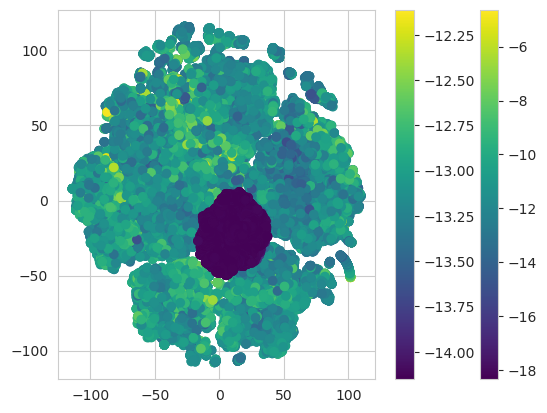

In [126]:
# plot TSNE of mol2vec, use target as color
_ = plt.scatter(mol2vec_tsne[:, 0], mol2vec_tsne[:, 1], c=target[:50000], cmap='viridis')
_ = plt.colorbar()
_ = plt.scatter(X_positions_tsne[:, 0], X_positions_tsne[:, 1], c=x_scores, cmap='viridis')
    # add two colorbar with name
plt.colorbar()

In [73]:
X_positions_pca = pca.transform(X_positions)

In [130]:
!mkdir images_tsne

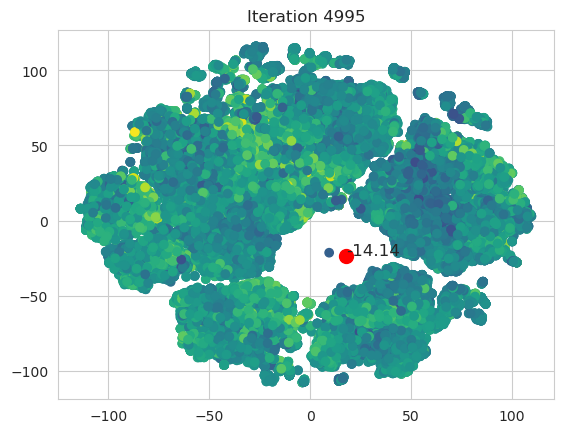

In [131]:
import imageio
images = []
for i in range(0, 5000, 5):
    plt.clf()
    plt.scatter(mol2vec_tsne[:, 0], mol2vec_tsne[:, 1], c=target[:50000], cmap='viridis')
    plt.scatter(X_positions_tsne[i, 0], X_positions_tsne[i, 1], c='red', s=100)
    plt.text(X_positions_tsne[i, 0], X_positions_tsne[i, 1], f'{x_scores[i]:.2f}', fontsize=12)
    plt.title(f'Iteration {i}')
    plt.savefig(f'images_tsne/{i}.png')
    images.append(imageio.v2.imread(f'images_tsne/{i}.png'))

In [151]:
# save as video
imageio.mimsave('movie_50k_lr0_1_tsne.mp4', images, fps=25)